# Performance - Final

### Preamble

In [7]:
SYS_PATH = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
SAVE_PATH = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original"
#SAVE_PATH = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original/seminar"
LOAD_PATH = r"C:/Users/mark/Documents/GitHub/honours/dev/package/analysis/output/temp/output.db"

In [8]:
#standard imports
import sys
import numpy as np
import scipy.stats as stats
import pandas as pd
from datetime import date, timedelta
import math
from itertools import chain

#third party imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as tkr
import seaborn as sns
from sklearn import metrics

In [9]:
import importlib
import sys; sys.path.append(SYS_PATH)
import analysis.helper as helper
import analysis.autoVC2 as vc
importlib.reload(helper)
importlib.reload(vc)
%matplotlib inline

In [10]:
plt.style.use(['seaborn-white', 'seaborn-paper'])

In [13]:
palette = ["#244397", "#3754A0", "#5F76B3","#D3D3D3", "#E8CC77", "#DCAF2A"] #"colorblind"
TINY_SIZE, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE  = 16, 24, 30, 36
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['figure.figsize'] = (12, 6) #(8,3)
pd.set_option('precision',3)

In [14]:
sns.set_palette(palette)
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

### Performance variation by slice date

In [38]:
reload = True

In [39]:
chart_id = "figures/evaluation/performance_slice"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [40]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(33, "evaluate")
    data = data[["F1","MCC","PRC","ROC", "feature_date_str", "forecast_window_years"]]
    data = data.loc[data["forecast_window_years"] == "2 Years"]
    total = pd.DataFrame()
    for metric in ["F1","MCC","PRC","ROC"]:
        temp = data[[metric,"feature_date_str"]]
        temp = temp.rename(index=str, columns={metric: "Score"})
        temp["Metric"] = metric
        total = pd.concat([temp, total], ignore_index=True)
    data = total
    data.to_pickle(pickle_path)

In [41]:
x = "Metric"
y = "Score"
hue = "feature_date_str"
order = ["ROC", "PRC", "MCC", "F1"]
hue_order = data.groupby(hue)[y].mean().index.sort_values(ascending=True).tolist()

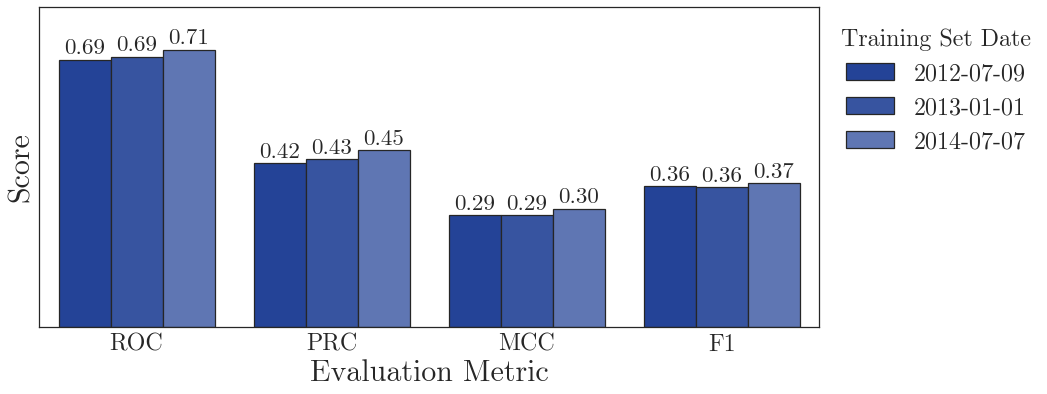

In [42]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, hue=hue, order=order, hue_order=hue_order, ci =None,saturation =1, **outline_bars)
helper.auto_label(ax, fmt='{:,.2f}', size=SMALL_SIZE-1)
ax.set_ylabel("Score")
ax.set_xlabel("Evaluation Metric")
plt.legend(bbox_to_anchor=(1,1), title="Training Set Date", loc='upper left')
plt.tight_layout()

In [ ]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Performance by forecast window

In [43]:
reload = True

In [44]:
chart_id = "figures/evaluation/performance_window"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [45]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(33, "evaluate")
    data = data[["F1","MCC","PRC","ROC", "feature_date_str", "forecast_window_years"]]
    total = pd.DataFrame()
    mtrics = ["F1","MCC","PRC","ROC"]
    for metric in mtrics:
        temp = data[[metric,"feature_date_str", "forecast_window_years"]]
        temp = temp.rename(index=str, columns={metric: "Score"})
        temp["Metric"] = metric
        total = pd.concat([temp, total], ignore_index=True)
    data = total
    data.to_pickle(pickle_path)

In [46]:
x = "Metric" 
y = "Score"
hue = "forecast_window_years"
order = ["ROC", "PRC", "MCC", "F1"]
hue_order = ["2 Years", "3 Years", "4 Years"]

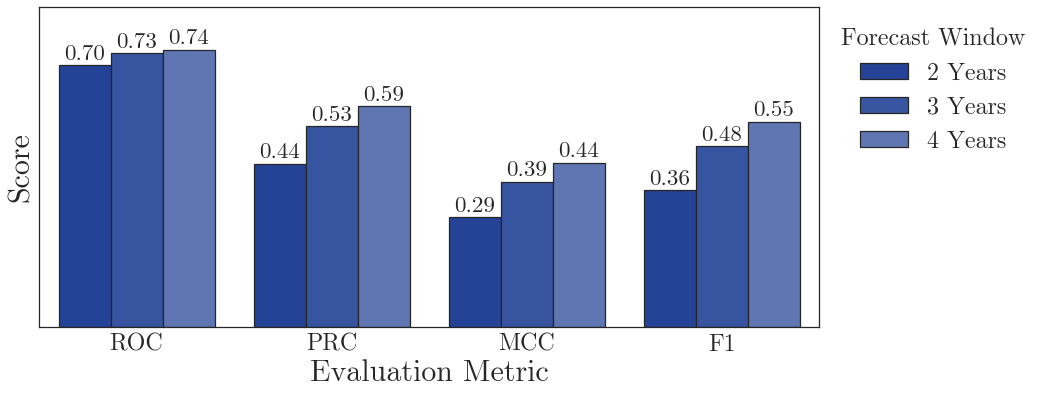

In [48]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, hue=hue, order=order, hue_order=hue_order, saturation = 1, ci=None, **outline_bars)
helper.auto_label(ax, fmt='{:,.2f}', size=SMALL_SIZE-1)
ax.set_ylabel("Score")
ax.set_xlabel("Evaluation Metric")
plt.legend(bbox_to_anchor=(1,1), loc='upper left',title="Forecast Window")
plt.tight_layout()

In [ ]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Performance by developmental stage

In [15]:
reload = True

In [16]:
chart_id = "figures/evaluation/performance_stage"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [17]:
def get_set(n, name, individual=True):
    data = helper.get_results(*n)
    if individual: stage = "feature_stage_single"
    else: stage = "feature_stage"
    data = data.loc[data["forecast_window_years"] == "4 Years"].reset_index(drop=True)
    data = data[["Y_Pred", "Y_True","feature_date_str", stage]]
    data = helper.get_feature_values(data)
    results = helper.feature_function(data, metrics.f1_score, group = [stage])
    overall = helper.feature_function(data, metrics.f1_score)
    results["Overall"] = overall
    if type(results) is pd.Series: results = results.to_frame()
    results["method"] = name
    return results

In [18]:
def get_data():
    results1 = get_set((33, "evaluate"), "Combined", individual=False)
    results2 = get_set((34, "evaluate"), "Individual", individual=True)
    results = pd.concat([results1, results2], axis=0)
    results = results.reset_index(drop=False)
    results = results.rename(index=str, columns={0:"score","index":"stage"})
    data = results
    return data

In [19]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

In [20]:
x = "stage"
y = "score"
hue = "method"
hue_order = ['Combined', "Individual"]

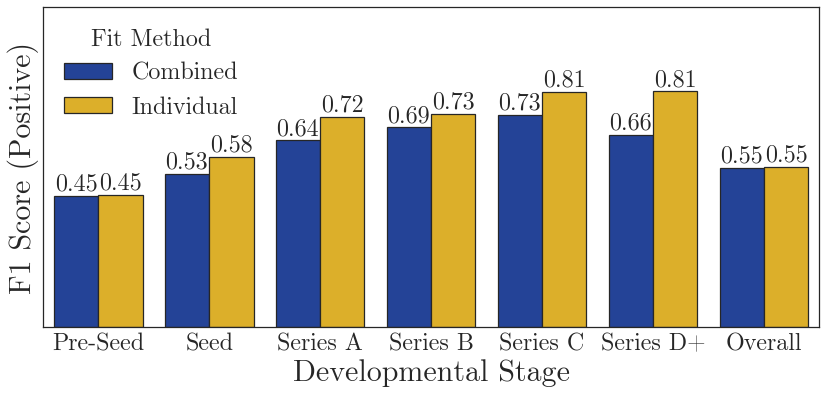

In [34]:
with sns.color_palette([palette[0], palette[5]]):
    f = plt.figure()
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order,saturation=1, **outline_bars)
    ax.set_ylim(ymax=1)
    helper.auto_label(ax, fmt='{:,.2f}',size=SMALL_SIZE)
    ax.set_xlabel("Developmental Stage")
    ax.set_ylabel("F1 Score (Positive)")
    plt.legend(title="Fit Method", loc="upper left") #bbox_to_anchor=(1,1.05), 
    plt.tight_layout()

In [36]:
chart_id = "poster/figures/system_performance"
output_path = "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Performance by target outcome

In [60]:
reload = True

In [61]:
chart_id = "figures/evaluation/performance_outcome"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [62]:
def get_data():
    data = helper.get_results(35, "evaluate")
    data["label_type"] = data["label_type"].apply(lambda x: x.replace("_"," "))
    data = data[["Y_Pred", "Y_True", "label_type","forecast_window_years"]]
    data = helper.get_feature_values(data)
    results = helper.feature_function(data, metrics.f1_score, group = ["forecast_window_years","label_type"])
    if type(results) is pd.Series: results = results.to_frame()
    results = results.reset_index(drop=False)
    results = results.rename(index=str, columns={0:"score","index":"label_type"})
    data = results
    return data

In [63]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

In [64]:
x = "label_type"
y = "score"
hue= "forecast_window_years"
order = ["Extra Stage", "Extra Round", "Exit", "Acquisition", "IPO"]

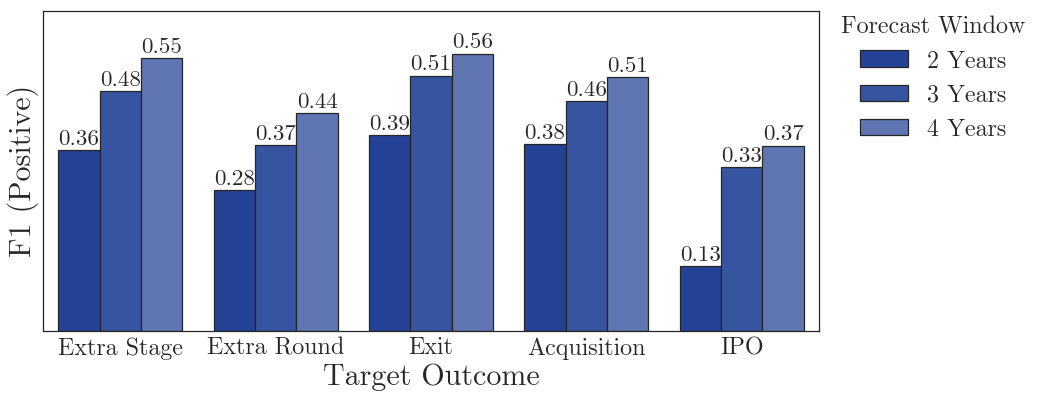

In [66]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, hue=hue, order=order,saturation=1, **outline_bars)
helper.auto_label(ax, fmt='{:,.2f}',size=SMALL_SIZE-1)
ax.set_xlabel("Target Outcome")
ax.set_ylabel("F1 (Positive)")
plt.legend(bbox_to_anchor=(1,1.05), title="Forecast Window")
plt.tight_layout()

In [ ]:
output_path = "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Classification report by slice date

In [ ]:
reload=True

In [ ]:
chart_id = "tables/evaluation/clf_report_slice"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [ ]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(33, "evaluate")
    data["feature_date_year"] = data["feature_date"].apply(lambda x: x.year)
    data = data.loc[data["forecast_window_years"] == "2 Years"].reset_index(drop=True)
    data = data[["Y_Pred", "Y_True", "feature_date_year"]]
    data = helper.get_feature_values(data)
    data.to_pickle(pickle_path)

In [ ]:
group = ["feature_date_year"]
cl_reports = helper.feature_function(data, metrics.classification_report, group = group)
cf_matrix = helper.feature_function(data, metrics.confusion_matrix, group = group)
acc_scores = helper.feature_function(data, metrics.accuracy_score, group = group)
for i, (index, rep) in enumerate(cl_reports.iteritems()):
    print(index)
    print("{0:.2f}".format(acc_scores.tolist()[i]))
    print(cf_matrix.tolist()[i])
    print(rep)

### Classification report by slice size

In [ ]:
reload=False

In [ ]:
chart_id = "tables/evaluation/clf_report_size"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [ ]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(36, "evaluate")
    data["feature_date_year"] = data["feature_date"].apply(lambda x: x.year)
    data = data.loc[data["forecast_window_years"] == "4 Years"].reset_index(drop=True)
    data = data.loc[data["label_type"] == "Extra Stage"].reset_index(drop=True)
    data = data[["Y_Pred", "Y_True", "dataset_size"]]
    data = helper.get_feature_values(data)
    data.to_pickle(pickle_path)

In [ ]:
group = ["dataset_size"]
cl_reports = helper.feature_function(data, metrics.classification_report, group = group)
cf_matrix = helper.feature_function(data, metrics.confusion_matrix, group = group)
acc_scores = helper.feature_function(data, metrics.accuracy_score, group = group)
for i, (index, rep) in enumerate(cl_reports.iteritems()):
    print(index)
    print("{0:.2f}".format(acc_scores.tolist()[i]))
    print(cf_matrix.tolist()[i])
    print(rep)

### Classification report by forecast window

In [ ]:
reload=True

In [ ]:
chart_id = "tables/evaluation/clf_report_window"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [ ]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(33, "evaluate")
    data = data[["Y_Pred", "Y_True", "forecast_window_years"]]
    data = helper.get_feature_values(data)
    data.to_pickle(pickle_path)

In [ ]:
group = ["forecast_window_years"]
cl_reports = helper.feature_function(data, metrics.classification_report, group = group)
cf_matrix = helper.feature_function(data, metrics.confusion_matrix, group = group)
acc_scores = helper.feature_function(data, metrics.accuracy_score, group = group)
for i, (index, rep) in enumerate(cl_reports.iteritems()):
    print(index)
    print("{0:.2f}".format(acc_scores.tolist()[i]))
    print(cf_matrix.tolist()[i])
    print(rep)

### Classification report by developmental stage

In [ ]:
reload=True

In [ ]:
chart_id = "tables/evaluation/clf_report_stage"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [ ]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(34, "evaluate")
    data = data.loc[data["forecast_window_years"] == "4 Years"].reset_index(drop=True)
    data = data[["Y_Pred", "Y_True", "feature_stage"]]
    data = helper.get_feature_values(data)
    data.to_pickle(pickle_path)

In [ ]:
group = ["feature_stage"]
cl_reports = helper.feature_function(data, metrics.classification_report, group = group)
cf_matrix = helper.feature_function(data, metrics.confusion_matrix, group = group)
acc_scores = helper.feature_function(data, metrics.accuracy_score, group = group)
for i, (index, rep) in enumerate(cl_reports.iteritems()):
    print(index)
    print("{0:.2f}".format(acc_scores.tolist()[i]))
    print(cf_matrix.tolist()[i])
    print(rep)

### Classification report by target outcome

In [ ]:
reload=True

In [ ]:
chart_id = "tables/evaluation/clf_report_outcome"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [ ]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(35, "evaluate")
    data = data.loc[data["forecast_window_years"] == "4 Years"].reset_index(drop=True)
    data = data[["Y_Pred", "Y_True", "label_type"]]
    data = helper.get_feature_values(data)
    data.to_pickle(pickle_path)

In [ ]:
group = ["label_type"]
cl_reports = helper.feature_function(data, metrics.classification_report, group = group)
cf_matrix = helper.feature_function(data, metrics.confusion_matrix, group = group)
acc_scores = helper.feature_function(data, metrics.accuracy_score, group = group)
for i, (index, rep) in enumerate(cl_reports.iteritems()):
    print(index)
    print("{0:.2f}".format(acc_scores.tolist()[i]))
    print(cf_matrix.tolist()[i])
    print(rep)

### Example company profiles and their predictions

In [ ]:
reload = True

In [ ]:
chart_id = "tables/discussion/example_profiles"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [ ]:
def get_data():
    data = helper.get_results(33, "evaluate")
    return data

In [ ]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

In [ ]:
features_stage_info = dict(
    Age = 'confidence_context_economy_company_age_number',
    FundingRounds = 'confidence_validation_funding_rounds_number',
    FundingRaised = 'confidence_validation_funding_raised_value_total_number',
    SeriesA = 'confidence_validation_funding_round_codes_list_a',
    SeriesB = 'confidence_validation_funding_round_codes_list_b',
    SeriesC = 'confidence_validation_funding_round_codes_list_c',
    SeriesD = 'confidence_validation_funding_round_codes_list_d',
    SeriesE = 'confidence_validation_funding_round_codes_list_e',
    SeriesF = 'confidence_validation_funding_round_codes_list_f',
    SeriesG = 'confidence_validation_funding_round_codes_list_g',
    SeriesH = 'confidence_validation_funding_round_codes_list_h',
    Closed = "keys_company_status_closed_bool",
    Acquired = "keys_company_status_acquired_bool",
    IPO = "keys_company_status_ipo_bool"
)

label_stage_info = dict(
    Age = 'outcome_age_number',
    FundingRounds = 'outcome_funding_rounds_number',
    FundingRaised = 'outcome_funding_raised_value_total_number',
    SeriesA = 'outcome_funding_round_codes_list_a',
    SeriesB = 'outcome_funding_round_codes_list_b',
    SeriesC = 'outcome_funding_round_codes_list_c',
    SeriesD = 'outcome_funding_round_codes_list_d',
    SeriesE = 'outcome_funding_round_codes_list_e',
    SeriesF = 'outcome_funding_round_codes_list_f',
    SeriesG = 'outcome_funding_round_codes_list_g',
    SeriesH = 'outcome_funding_round_codes_list_h',
    Closed = "outcome_closed_bool",
    Acquired = "outcome_acquired_bool",
    IPO = "outcome_ipo_bool"
)

In [ ]:
df = pd.read_csv(SYS_PATH+"analysis/output/autoVC/26/evaluate/2013-04-09_2017-04-04.csv")
df = vc.add_stages(df, features_stage_info, "feature")
df = vc.add_stages(df, label_stage_info, "label")
df = vc.apply_constraints(df)
X, y, keys = vc.finalise_dataset(df)
source_data = df

In [ ]:
results_data = helper.get_results(33, "evaluate")
results_data = results_data.loc[results_data["forecast_window_years"] == "4 Years"]
results_data = results_data.sample(1).squeeze()

In [ ]:
data = pd.concat([source_data, pd.Series(results_data["Y_Pred"], index=source_data.index, name="Y_Pred")], axis=1)

In [ ]:
data["Missing"] = data.isnull().sum(axis=1)
data["Y_True"] = data["outcome_extra_stage_bool"]
data["Correct"] = np.where(data["outcome_extra_stage_bool"] == data["Y_Pred"], 1, 0)
data.sort_values(by="Missing",ascending=True)[["keys_company_name_id", "keys_company_stage", "outcome_stage", "Y_True", "Y_Pred", "Correct"]].sample(50)

In [ ]:
elements = [
    "keys_company_name_id",
    "confidence_context_economy_company_age_number",
    "confidence_validation_funding_raised_value_total_number",
    "confidence_validation_funding_rounds_number",
    "keys_company_stage", 
    "outcome_age_number",
    "outcome_funding_raised_value_total_number",
    "outcome_funding_rounds_number",
    "outcome_stage", 
    "Y_Pred",
    "Y_True", 
    "Correct"]
names = ["ChaCha", "Doctor.com", "Fab", "Mixpanel"]
temp = pd.DataFrame()
for name in names:
    new = data.loc[data["keys_company_name_id"] == name][elements]
    temp = pd.concat([new, temp], axis=0)
temp.T